In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('treebank')

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print('품사 태킹이 된 문장의 개수:', len(tagged_sentences))

품사 태킹이 된 문장의 개수: 3914


In [3]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [4]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))

In [5]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


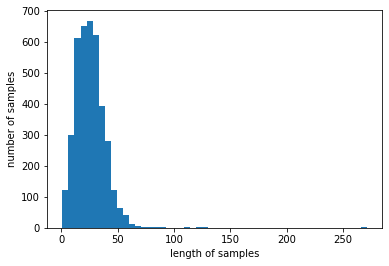

In [6]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [8]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [9]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index)+1
print('단어 집합의 크기:',vocab_size)
print('태킹 정보 집합의 크기:', tag_size)

단어 집합의 크기: 11388
태킹 정보 집합의 크기: 47


In [10]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)


In [11]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [12]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [15]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [16]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


In [17]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
# from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [20]:
model.fit(X_train, y_train, batch_size=128, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
25/25 [==============================] - 24s 949ms/step - loss: 0.5719 - accuracy: 0.0569 - val_loss: 0.5073 - val_accuracy: 0.0286
Epoch 2/6
25/25 [==============================] - 23s 903ms/step - loss: 0.4937 - accuracy: 0.0357 - val_loss: 0.4665 - val_accuracy: 0.0564
Epoch 3/6
25/25 [==============================] - 23s 912ms/step - loss: 0.4192 - accuracy: 0.0719 - val_loss: 0.3387 - val_accuracy: 0.0867
Epoch 4/6
25/25 [==============================] - 23s 929ms/step - loss: 0.2654 - accuracy: 0.1045 - val_loss: 0.1951 - val_accuracy: 0.1228
Epoch 5/6
25/25 [==============================] - 23s 935ms/step - loss: 0.1408 - accuracy: 0.1406 - val_loss: 0.1049 - val_accuracy: 0.1467
Epoch 6/6
25/25 [==============================] - 22s 896ms/step - loss: 0.0718 - accuracy: 0.1562 - val_loss: 0.0685 - val_accuracy: 0.1534


In [21]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 2s 97ms/step - loss: 0.0685 - accuracy: 0.1534

 테스트 정확도: 0.1534


In [22]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
